## Importing libraries

In [2]:
import os
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.applications.vgg16 import preprocess_input
import cv2
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models, optimizers, Input
from PIL import Image, ImageOps
import random

## Setting seed

In [3]:
def set_seed(seed=42):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
set_seed(42)

## Reading data

In [4]:
def load_dataset(image_dir, gt_dir, target_size=(224, 224)):
    X = []
    y = []
    c = 0
    image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
    image_files.sort()  # opcjonalnie

    if not image_files:
        raise ValueError("Brak plików .jpg w podanym katalogu!")

    for img_file in image_files:
        img_path = os.path.join(image_dir, img_file)
        mat_path = os.path.join(gt_dir, 'GT_' + img_file.replace('.jpg', '.mat'))

        # Wczytaj i przeskaluj obraz do dokładnego rozmiaru target_size (bez paddingu)
        img = Image.open(img_path).convert('RGB')
        img_resized = img.resize(target_size, Image.LANCZOS)

        # Konwersja do numpy + preprocess_input (dla MobileNet)
        img_array = np.array(img_resized, dtype=np.float32)
        img_array = preprocess_input(img_array)

        # Wczytaj ground truth (liczba osób)
        mat = scipy.io.loadmat(mat_path)
        count = len(mat['image_info'][0][0][0][0][0])

        X.append(img_array)
        y.append(count)
        # if c == 1:
        #     plt.imshow(img_resized)
        #     print(img_path)
        #     print(count)
        #     break
        # c += 1

    return np.array(X), np.array(y)

## Getting the training set and the test set

In [5]:
X_train, y_train = load_dataset('ShanghaiTech/part_B/train_data/images/', 'ShanghaiTech/part_B/train_data/ground-truth/')

In [6]:
X_test, y_test = load_dataset('ShanghaiTech/part_B/test_data/images/', 'ShanghaiTech/part_B/test_data/ground-truth/')

## Building the model

In [7]:
input_tensor = Input(shape=(224, 224, 3))

base_model = VGG16(include_top=False, input_tensor=input_tensor, weights='imagenet')
base_model.trainable = True

for layer in base_model.layers[:-3]:
    layer.trainable = False

x = base_model.output
x = layers.Flatten()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(64, activation='relu')(x)
output = layers.Dense(1, activation='linear')(x)

model = models.Model(inputs=input_tensor, outputs=output)
model.compile(optimizer=Adam(1e-4), loss='mse', metrics=['mae'])

## Data augmentation and training the model

In [8]:
# Function to augment
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1),
])

def augment(x, y):
    return data_augmentation(x), y

training_set = tf.data.Dataset.from_tensor_slices((X_train, y_train))
training_set = training_set.map(augment)  # augment
training_set = training_set.batch(32).prefetch(tf.data.AUTOTUNE)
history = model.fit(training_set, batch_size=32,
    epochs=20, shuffle=True, validation_data=(X_test, y_test)
)

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 144s 11s/step - loss: 18291.4160 - mae: 104.7933 - val_loss: 8625.3145 - val_mae: 56.5217
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 141s 11s/step - loss: 8655.8662 - mae: 68.0799 - val_loss: 6514.7847 - val_mae: 46.7426
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 140s 11s/step - loss: 5992.6211 - mae: 53.3714 - val_loss: 4660.7593 - val_mae: 39.1099
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 140s 11s/step - loss: 5542.6821 - mae: 50.1088 - val_loss: 4043.1255 - val_mae: 38.2742
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 140s 11s/step - loss: 3943.6616 - mae: 41.8627 - val_loss: 4641.2642 - val_mae: 44.4263
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 144s 11s/step - loss: 3443.0220 - mae: 41.3727 - val_loss: 2843.2588 - val_mae: 33.0039
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 143s 11s/step - loss: 3029.6682 - mae: 37.6780 - val_loss: 2853.1389 - val_mae: 33.9521
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 142s 11s/step - loss: 3027.1526 - mae: 37.2136 - val_loss: 2947.2588 - val_mae

## Training curves visualisation

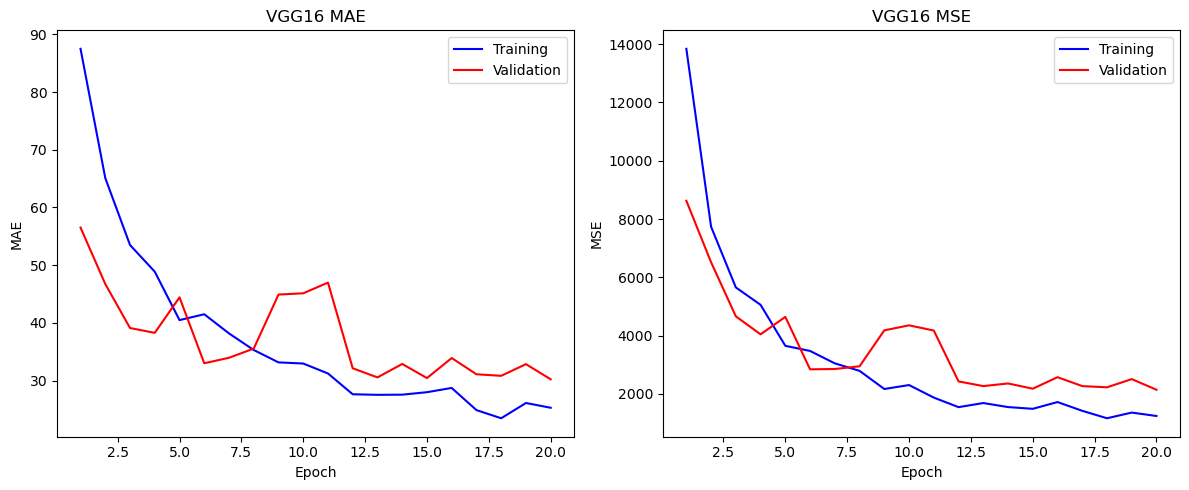

In [9]:
history_dict = history.history

# Getting the metrics
mae = history_dict['mae']
val_mae = history_dict.get('val_mae')
loss = history_dict['loss']
val_loss = history_dict.get('val_loss')

epochs = range(1, len(mae) + 1)

# MAE
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, mae, 'b-', label='Training')
if val_mae:
    plt.plot(epochs, val_mae, 'r-', label='Validation')
plt.title('VGG16 MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

# Loss (MSE)
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b-', label='Training')
if val_loss:
    plt.plot(epochs, val_loss, 'r-', label='Validation')
plt.title('VGG16 MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

plt.tight_layout()
plt.show()

## Making predictions

In [10]:
y_pred = np.round(model.predict(X_test))

10/10 ━━━━━━━━━━━━━━━━━━━━ 54s 5s/step 


'input_layer', 'block1_conv1', 'block1_conv2', 'block1_pool', 'block2_conv1', 'block2_conv2', 'block2_pool', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block3_pool', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block4_pool', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_pool', 'flatten', 'dropout', 'dense', 'dropout_1', 'dense_1', 'dense_2'

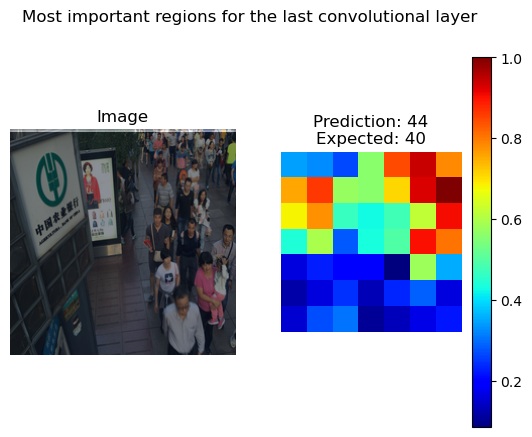

In [40]:
# Sample
image = X_test[20:21]

# Layer
last_conv_layer_name = 'block5_pool'

# Grad-CAM model
last_conv_layer = model.get_layer(last_conv_layer_name)
grad_model = tf.keras.models.Model(
    inputs=model.inputs,
    outputs=[last_conv_layer.output, model.output]
)

with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(image)
    loss = predictions[:, 0]  # regression

# Gradients
grads = tape.gradient(loss, conv_outputs)
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
conv_outputs = conv_outputs[0]
heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
heatmap = tf.squeeze(heatmap)

# Heatmap normalization
heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
heatmap = heatmap.numpy()

# Results
image_norm = image[0]
image_norm = (image_norm - np.min(image_norm)) / (np.max(image_norm) - np.min(image_norm))
# preprocess_input scaled it to bgr
image_norm = cv2.cvtColor(image_norm, cv2.COLOR_BGR2RGB)
plt.suptitle("Most important regions for the last convolutional layer")
plt.subplot(1, 2, 1)
plt.imshow(image_norm)
plt.title("Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(heatmap, cmap='jet')
plt.colorbar()
plt.axis('off')
plt.title(f"Prediction: {np.round(predictions.numpy()[0][0]).astype('int64')}"
          f"\nExpected: {y_test[20]}")

plt.show()

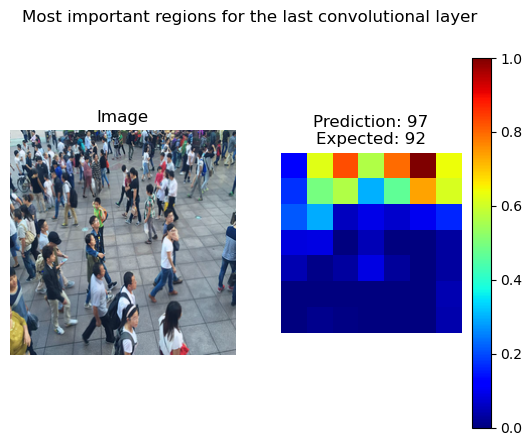

In [41]:
# Sample
image = X_test[211:212]

# Layer
last_conv_layer_name = 'block5_pool'

# Grad-CAM model
last_conv_layer = model.get_layer(last_conv_layer_name)
grad_model = tf.keras.models.Model(
    inputs=model.inputs,
    outputs=[last_conv_layer.output, model.output]
)

with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(image)
    loss = predictions[:, 0]  # regression

# Gradients
grads = tape.gradient(loss, conv_outputs)
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
conv_outputs = conv_outputs[0]
heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
heatmap = tf.squeeze(heatmap)

# Heatmap normalization
heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
heatmap = heatmap.numpy()

# Results
image_norm = image[0]
image_norm = (image_norm - np.min(image_norm)) / (np.max(image_norm) - np.min(image_norm))
# preprocess_input scaled it to bgr
image_norm = cv2.cvtColor(image_norm, cv2.COLOR_BGR2RGB)
plt.suptitle("Most important regions for the last convolutional layer")
plt.subplot(1, 2, 1)
plt.imshow(image_norm)
plt.title("Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(heatmap, cmap='jet')
plt.colorbar()
plt.axis('off')
plt.title(f"Prediction: {np.round(predictions.numpy()[0][0]).astype('int64')}"
          f"\nExpected: {y_test[211]}")

plt.show()

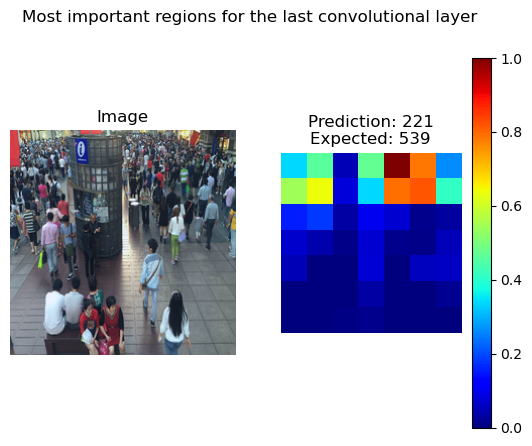

In [42]:
# Sample
image = X_test[289:290]

# Layer
last_conv_layer_name = 'block5_pool'

# Grad-CAM model
last_conv_layer = model.get_layer(last_conv_layer_name)
grad_model = tf.keras.models.Model(
    inputs=model.inputs,
    outputs=[last_conv_layer.output, model.output]
)

with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(image)
    loss = predictions[:, 0]  # regression

# Gradients
grads = tape.gradient(loss, conv_outputs)
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
conv_outputs = conv_outputs[0]
heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
heatmap = tf.squeeze(heatmap)

# Heatmap normalization
heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
heatmap = heatmap.numpy()

# Results
image_norm = image[0]
image_norm = (image_norm - np.min(image_norm)) / (np.max(image_norm) - np.min(image_norm))
# preprocess_input scaled it to bgr
image_norm = cv2.cvtColor(image_norm, cv2.COLOR_BGR2RGB)
plt.suptitle("Most important regions for the last convolutional layer")
plt.subplot(1, 2, 1)
plt.imshow(image_norm)
plt.title("Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(heatmap, cmap='jet')
plt.colorbar()
plt.axis('off')
plt.title(f"Prediction: {np.round(predictions.numpy()[0][0]).astype('int64')}"
          f"\nExpected: {y_test[289]}")

plt.show()

In [43]:
y_pred.reshape(len(y_pred), 1)
y_test.reshape(len(y_test), 1)
print(np.concatenate((y_pred.reshape(len(y_pred), 1), y_test.reshape(len(y_test), 1)), 1))

[[ 31.  23.]
 [196. 181.]
 [132. 157.]
 [ 33.  37.]
 [ 51.  70.]
 [ 47.  57.]
 [ 49.  44.]
 [348. 227.]
 [165. 165.]
 [451. 476.]
 [159. 139.]
 [296. 316.]
 [240. 164.]
 [ 77. 110.]
 [ 42.  20.]
 [218. 131.]
 [ 64.  48.]
 [217. 183.]
 [140. 101.]
 [282. 204.]
 [ 54.  40.]
 [135. 143.]
 [181. 146.]
 [368. 513.]
 [ 58.  70.]
 [170. 175.]
 [ 26.  51.]
 [ 78.  55.]
 [ 79.  67.]
 [ 40.  72.]
 [ 44.  56.]
 [118. 165.]
 [ 30.  32.]
 [212. 149.]
 [ 46.  48.]
 [146.  80.]
 [ 83. 117.]
 [ 80. 162.]
 [196. 137.]
 [ 88. 120.]
 [ 51.  72.]
 [150. 122.]
 [150. 198.]
 [139. 133.]
 [101. 147.]
 [ 39.  29.]
 [ 69.  70.]
 [ 34.  35.]
 [ 68.  24.]
 [350. 251.]
 [ 36.  59.]
 [106.  67.]
 [ 40.  61.]
 [294. 248.]
 [326. 252.]
 [151. 147.]
 [ 58.  57.]
 [108. 121.]
 [ 44.  47.]
 [375. 505.]
 [322. 297.]
 [326. 465.]
 [128. 167.]
 [ 59.  43.]
 [ 35.  46.]
 [111.  91.]
 [257. 263.]
 [129.  92.]
 [ 74. 117.]
 [ 38.  48.]
 [ 55.  54.]
 [ 98.  73.]
 [ 63. 122.]
 [ 68.  60.]
 [216. 170.]
 [ 91. 167.]
 [ 34.  57.]

## Metrics

In [44]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
print("R2:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", root_mean_squared_error(y_test, y_pred))

R2: 0.7635027170181274
MSE: 2140.33544921875
MAE: 30.221519470214844
RMSE: 46.26375961303711
